In [1]:
import requests, pandas as pd
from io import StringIO


url = (
    "https://service.iris.edu/fdsnws/event/1/query?"
    "starttime=1990-01-01&"
    "endtime=2018-02-19T23%3A59%3A59.999999&"
    "minmagnitude=5.5&"
    # "maxmagnitude=10&"
    # "minlatitude=-90.0&"
    # "maxlatitude=90.0&"
    # "minlongitude=-180.0&"
    # "maxlongitude=180.0&"
    "mindepth=0&"
    "maxdepth=100000&"
    "output=text&"
    "nodata=404"
)


r = requests.get(url, timeout=60)
r.raise_for_status()
df = pd.read_csv(StringIO(r.text), delimiter="|")
df.to_csv('./raw_events.csv')
print(len(df), "events")
print(df.head())

12928 events
   #EventID                 Time    Latitude    Longitude    Depth/km   \
0   10644693  2018-02-19T06:57:01     16.4993     -97.5790       40.17   
1   10643950  2018-02-17T00:36:52     16.1583     -97.8817        4.26   
2   10643929  2018-02-16T23:39:39     16.3887     -97.9789       25.98   
3   10643487  2018-02-15T08:27:22     -0.0684     -17.8411       10.00   
4   10642616  2018-02-13T02:39:53     12.3644      93.1316       69.37   

    Author   Catalog   Contributor                     ContributorID   \
0        us  NEIC PDE            us                        us2000d4lg   
1        us  NEIC PDE            us                        us2000d3m0   
2  at,pt,us  NEIC PDE            us  pt18047000,at00p49oe8,us2000d3km   
3        us  NEIC PDE            us                        us2000d2jg   
4        us  NEIC PDE            us                        us2000d1a1   

   MagType    Magnitude   MagAuthor               EventLocationName  
0       Mww          5.9         

In [8]:
import numpy as np 


df.columns = df.columns.str.strip()

lons = np.radians(df['Longitude'].values)
lats = np.radians(df['Latitude'].values)
times = df['Time'].values


depths = df['Depth/km'].values
depths[np.isnan(depths)] = -1.0
mags = df['Magnitude'].values

In [4]:
# create a total dict 
eqs = {}
eqs['lons'] = df['Longitude'].values
eqs['lats'] = df['Latitude'].values
eqs['depths'] = df['Depth/km'].values
eqs['mags'] = df['Magnitude'].values
print(eqs)

{'lons': array([ -97.579 ,  -97.8817,  -97.9789, ...,   92.9744, -172.9087,
        144.4179]), 'lats': array([ 16.4993,  16.1583,  16.3887, ..., -10.6437, -15.4219,  13.3906]), 'depths': array([ 40.17,   4.26,  25.98, ...,  15.  ,  42.6 , 148.5 ]), 'mags': array([5.9, 5.8, 7.2, ..., 5.9, 6.4, 5.8])}


In [9]:
# use the times to get the year, month, day
years = np.zeros(times.shape, dtype=int)
months = np.zeros(times.shape, dtype=int)
days = np.zeros(times.shape, dtype=int)

for i in range(times.shape[0]):
    years[i] = int(times[i][0:4])
    months[i] = int(times[i][5:7])
    days[i] = int(times[i][8:10])
    
# split the eqs per year and use the year as the key and store the data in a dictionary
eqs_per_year = {}
years_uniq = np.unique(years)
for year in years_uniq:
    eqs_per_year[year] = {'lons':[], 'lats':[], 'depths':[], 'mags':[]}
    eqs_per_year[year]['lons'] = lons[years == year]
    eqs_per_year[year]['lats'] = lats[years == year]
    eqs_per_year[year]['depths'] = depths[years == year]
    eqs_per_year[year]['mags'] = mags[years == year]


# find the nearest mesh vertex as the support point for the eqs 

In [10]:
import stripy
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


mesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3, include_face_points=True, tree=True)
lons0 = np.degrees(mesh.lons)
lats0 = np.degrees(mesh.lats)


#### visualize the mesh and use the level 1 to show better clarity

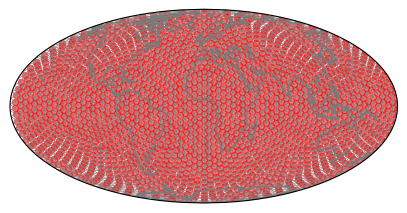

In [11]:
fig = plt.figure(figsize=(5, 6.6), facecolor="none")

ax = plt.subplot(111, projection=ccrs.Mollweide(central_longitude=0.0,  globe=None))
ax.coastlines(color="#777777")
ax.set_global()
ax.scatter(lons0, lats0, color="Red", alpha=0.5,
                 marker="o", s=20, transform=ccrs.PlateCarree())


segs = mesh.identify_segments()

for s1, s2 in segs:
    ax.plot( [lons0[s1], lons0[s2]],
              [lats0[s1], lats0[s2]], 
              linewidth=0.5, color="gray", transform=ccrs.Geodetic())
 
# plt.savefig("earth_mesh.pdf", dpi=300, facecolor='none', edgecolor='none', transparent=True, bbox_inches='tight')

In [12]:
distances, vertices = mesh.nearest_vertices(lons, lats, k=1)
nodes, ncounts = np.unique(vertices, return_counts=True)

hit_countn = np.zeros_like(mesh.lons)
hit_countn[nodes] = ncounts
eqs['mesh vertex'] = vertices


In [13]:
for year in years_uniq:
   _, eqs_per_year[year]['mesh vertex'] = mesh.nearest_vertices(eqs_per_year[year]['lons'] , eqs_per_year[year]['lats'], k=1)
   eqs_per_year[year]['mesh vertex'] = eqs_per_year[year]['mesh vertex'].reshape(-1)

### now we have two dicts: one is eqs total and one is eqs per year 

In [14]:
eqs_per_year[2018]['mesh vertex'], eqs_per_year[2018]['mags'], eqs['mags']

(array([ 170,  170,  170,   57, 1578,  486,  486,  486, 1828,  412, 1828,
         940,  389, 1486,   16, 1208, 1161, 1702, 1161, 1161, 1161, 1533,
          85, 1687,  658, 1294, 1606, 1423, 1279,  915, 1333, 1294, 1603,
         946,  389,  242,  237,  241,  914, 1252,  914,  914,   82,  712,
         749,  372,  233, 1716,  389,  763,  882, 1279,  388, 1151, 1828,
         823,  698,  111,  724, 1746,    6]),
 array([5.9 , 5.8 , 7.2 , 5.6 , 5.6 , 5.6 , 5.7 , 6.  , 5.5 , 5.8 , 5.6 ,
        5.8 , 5.9 , 5.6 , 5.6 , 5.6 , 5.7 , 5.6 , 6.4 , 5.5 , 6.1 , 6.  ,
        5.5 , 6.  , 5.5 , 5.6 , 5.6 , 6.1 , 5.5 , 5.5 , 6.6 , 5.7 , 6.3 ,
        5.75, 5.7 , 6.2 , 5.8 , 6.3 , 5.5 , 5.6 , 5.6 , 7.9 , 6.  , 6.3 ,
        6.3 , 5.6 , 5.7 , 5.8 , 5.9 , 5.8 , 5.5 , 7.1 , 5.8 , 6.  , 5.5 ,
        5.5 , 7.5 , 5.8 , 5.5 , 5.5 , 5.9 ]),
 array([5.9, 5.8, 7.2, ..., 5.9, 6.4, 5.8]))

In [15]:
year_of_interest = 2008
# expand the signal of interest to the dimension of mesh vertices
signal = np.zeros_like(mesh.lons)
signal[eqs_per_year[year_of_interest]['mesh vertex']] = eqs_per_year[year_of_interest]['mags']

In [16]:
cmap = plt.cm.Reds

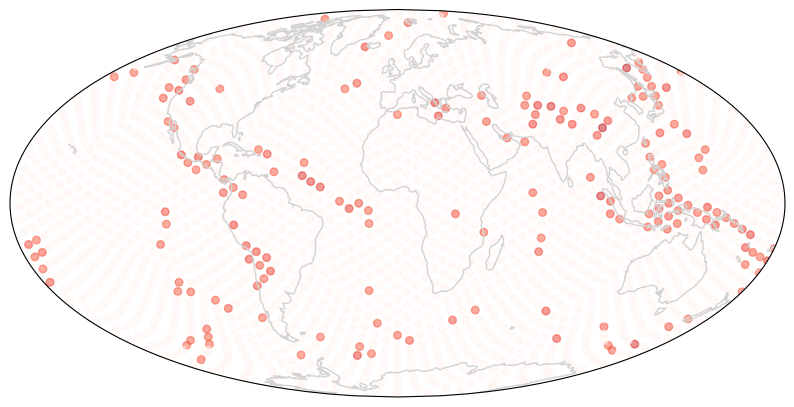

In [17]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="lightgrey", )
ax.set_global()

ax.scatter(lons0, lats0, 
            marker="o", s=30.0, transform=ccrs.PlateCarree(), c=signal, cmap=cmap, vmin=0.333, vmax=10.0, alpha=0.5)



### create a mesh graph 

In [18]:
import networkx as nx

In [19]:
# 1 nn finds the nodes themselves when using mesh.lons, mesh.lats
mesh_vertices = mesh.nearest_vertices(mesh.lons, mesh.lats, k=1)[1] .reshape(-1) # use the mesh vertices to build a graph 

/home/kacperwyrwal/topological-flow-matching/stripy-venv/lib/python3.10/site-packages/stripy/spherical.py:1600: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos((extxyz * vertxyz).sum(axis=1))


### notes
- if use mesh.nearest_vertices(lons,lats), we obtain the cloest mesh points for each coordinate, which makes sense since we want to allocate the eqs to the nearest mesh points.
- if the input is (mesh.lons,mesh.lats), we obtain the point itself included since the inputs are already mesh points.


In [20]:
# 1 nn finds the nodes themselves
mesh_vertices = mesh.nearest_vertices(lons, lats, k=1)[1].reshape(-1)
vertices, counts = np.unique(mesh_vertices, return_counts =True)
print('unique vertices total number', vertices.shape)

unique vertices total number (576,)


upto here, we did things reasonably because we want to build a graph using the collected eqs. 

In [21]:
k = 10
edges = []
# for node in mesh_vertices: # if building the graph from the mesh vertices
for node in vertices: 
    distances, nbrs = mesh.nearest_vertices(mesh.lons[node], mesh.lats[node], k=k)
    # print(node, distances, nbrs)
    nbr = nbrs[0][1:]
    distance = distances[0][1:]
    # print(node, distances, nbrs)
    for d, nbr in zip(distance, nbr):
        if nbr not in vertices:
            continue
        edges.append((node, nbr, {"dist": d}))

In [22]:
weights = [e[2]["dist"] for e in edges]
mean_weight =  np.mean(weights)

before we used unweighted with 10NN graph 

In [23]:
G = nx.Graph()
G.add_nodes_from(vertices)
# G.add_weighted_edges_from(edges)
# G.add_weighted_edges_from(list((edge[0], edge[1], edge[2]['dist']) for edge in edges))
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=1)
    
L = nx.laplacian_matrix(G, weight="weight").toarray()
L = nx.normalized_laplacian_matrix(G, weight="weight").toarray()
A = nx.adjacency_matrix(G, weight="weight").toarray()
D = np.diag(np.sum(A, axis=1))

degrees = np.diag(D)
print(G.number_of_nodes(), G.number_of_edges())

576 1526


In [24]:
# G = nx.Graph()
# G.add_nodes_from(vertices)
# for edge in edges:
#     G.add_edge(edge[0], edge[1], weight=1/((edge[2]['dist']/mean_weight)**2))
    
# L = nx.laplacian_matrix(G, weight="weight").toarray()
# L = nx.normalized_laplacian_matrix(G, weight="weight").toarray()
# A = nx.adjacency_matrix(G, weight="weight").toarray()
# D = np.diag(np.sum(A, axis=1))

# degrees = np.diag(D)
# print(G.number_of_nodes(), G.number_of_edges())

we prefer to build the graph only using the unique vertices which appeared in the eqs. 

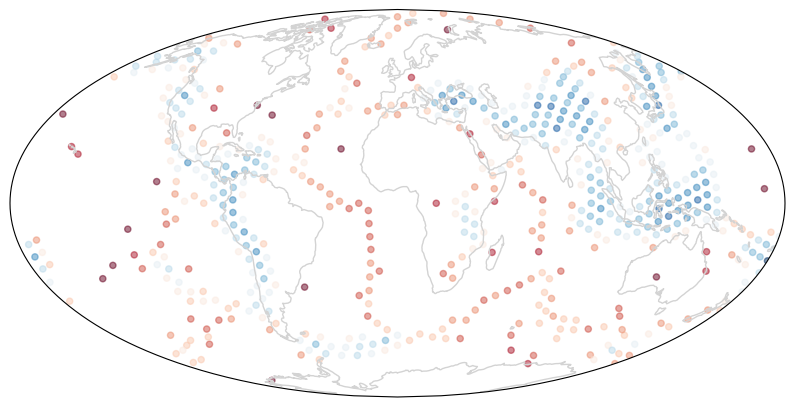

In [25]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="lightgrey", )
ax.set_global()

ax.scatter(lons0[G.nodes], lats0[G.nodes], 
            marker="o", s=20.0, transform=ccrs.PlateCarree(), c=degrees, cmap=plt.cm.RdBu, alpha=0.5)

# append the colorbar 
# plt.colorbar(ax.scatter([], [], c=[], cmap=plt.cm.RdBu), ax=ax, label='Degree of the node')


### use the signal per year as an individual signal on the graph

In [26]:
# use the nodes as keys and store the data in a dictionary
gs = {}
for year in years_uniq: 
    signal = {}
    for node in G.nodes:
        # find the mags at that node based on the stored vertices 
        iii = np.where(eqs_per_year[year]['mesh vertex']==node) # first find the index of the node in the mesh vertices
        if len(iii[0]) == 0:
            signal[node] = 0 # 0.333 # before we have 0
        else: 
            signal[node] = np.median(eqs_per_year[year]['mags'][iii])# np.mean(eqs_per_year[year]['mags'][iii])

    gs[year] = signal
    
# build the graph signal matrix
gs_matrix = []
for year in years_uniq:
    gs_matrix.append(list(gs[year].values()))

gs_matrix = np.array(gs_matrix)[:,:]

print(gs_matrix.shape)

(29, 576)


In [27]:
ori = gs_matrix.copy()
mean = np.mean(gs_matrix, axis=0)
std = np.std(gs_matrix, axis=0)
gs_min = np.min(gs_matrix)
# gs_min = 0.333
gs_max = np.max(gs_matrix)
# count the number of nodes with signals larger than 0.333
count = np.sum(gs_matrix > 0.333, axis=1)
count

gs_matrix = (gs_matrix - mean) #/ std
gs_matrix = 1 * (gs_matrix - gs_min) / (gs_max - gs_min) -0 ## performs better: normalization is more useful when the data is not normally distributed
# replace the nan values by the corresponding values in ori 
nan_indices = np.where(np.isnan(gs_matrix))
gs_matrix[nan_indices] = ori[nan_indices]

### use the total collections of eqs as a single signal on the graph --- NOT GOOD

In [28]:
# # use the nodes as keys and store the data in a dictionary
# gs = []
# for node in G.nodes:
#     # find the mags at that node based on the stored vertices 
#     iii = np.where(eqs['mesh vertex']==node)
#     if len(iii[0]) == 0:
#         signal[node] = 0.333
#     else:
#         signal[node] = np.mean(eqs['mags'][iii[0]])

# gs.append(list(signal.values()))
# gs = np.array(gs).T.reshape(-1)
# gs.shape
# mean = np.mean(gs, axis=0)
# std = np.std(gs, axis=0)
# gs_min = np.min(gs)
# gs_max = np.max(gs)
# print(gs_min, gs_max, mean, std)
# # gs = (gs - mean) / std
# gs = (gs - gs_min) / (gs_max - gs_min)

In [29]:
signal_of_interest = gs_matrix[19,:]
# signal_of_interest = gs

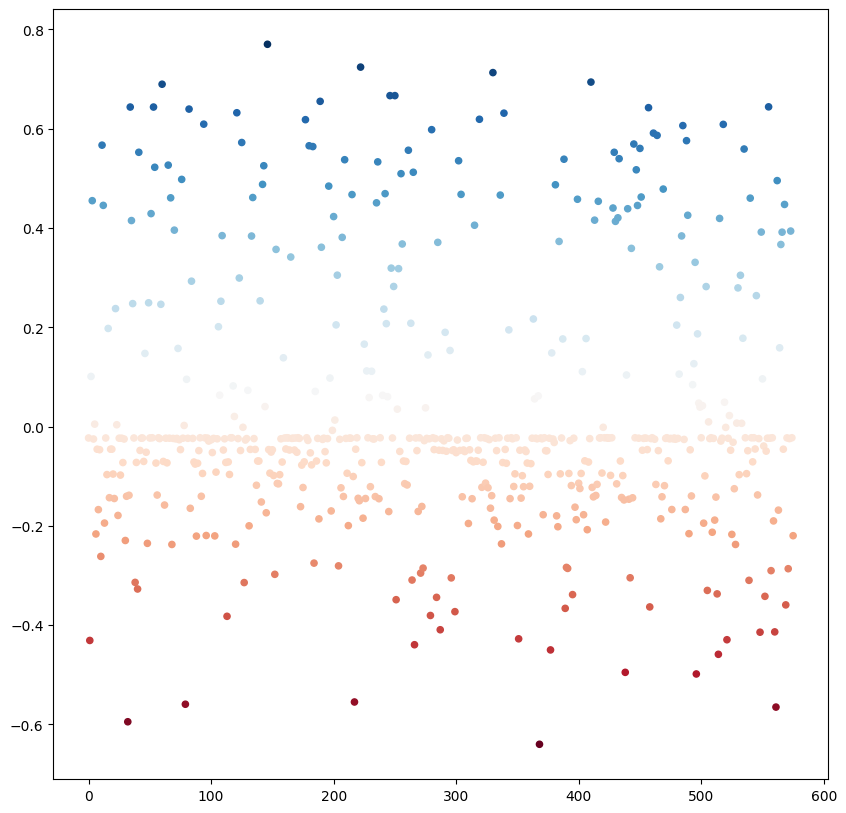

In [30]:
cmap = plt.cm.RdBu
# scatter the signal in a xy plot
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111)
ax.scatter(np.arange(0, len(signal_of_interest)), signal_of_interest, c=signal_of_interest, cmap=cmap, s=20.0)

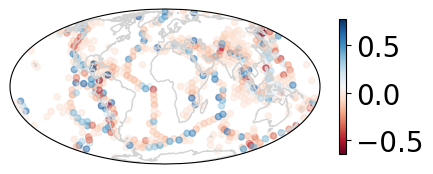

In [31]:
fig = plt.figure(figsize=(5, 2.5), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="lightgrey", )
ax.set_global()

ax.scatter(lons0[G.nodes], lats0[G.nodes], 
            marker="o", s=20.0, transform=ccrs.PlateCarree(), c=signal_of_interest, cmap=cmap, alpha=0.5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(signal_of_interest), vmax=max(signal_of_interest)))
sm._A = []
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.05, shrink=0.7)
# set colorbar tick size
cbar.ax.tick_params(labelsize=20)
# shrink the colorbar
# cbar.set_label('Magnitude')
# plt.show()
# plt.savefig("earthquake_data_sample.pdf", dpi=300, facecolor='none', edgecolor='none', transparent=True, bbox_inches='tight')

In [35]:
# check if L is symmetric
is_symmetric = np.allclose(L, L.T, atol=1e-8)

In [36]:
eigvals, eigvecs = np.linalg.eigh(L)

In [37]:
eigvals[-50:]

array([1.51543781, 1.52029268, 1.52222811, 1.52532961, 1.52590249,
       1.52695844, 1.53166012, 1.53377903, 1.53603572, 1.54259355,
       1.54357279, 1.54706175, 1.55447987, 1.56003141, 1.56492779,
       1.56504943, 1.57161261, 1.57784434, 1.58073413, 1.58621966,
       1.59876625, 1.60704246, 1.61154363, 1.61468333, 1.61668492,
       1.62077828, 1.63011478, 1.63213885, 1.63970324, 1.64413092,
       1.64623992, 1.66075602, 1.66894302, 1.67421734, 1.6813582 ,
       1.68403233, 1.70305366, 1.71570794, 1.74222507, 1.75639359,
       1.77325286, 1.77797135, 1.77996837, 1.81107352, 1.81512832,
       1.86160138, 1.93373335, 2.        , 2.        , 2.        ])

Save the data

In [38]:
# # # export the graph and data to a file
# import pickle
# with open("eqs.pkl", "wb") as f:
#     pickle.dump(G, f)
#     pickle.dump(L, f)
#     pickle.dump(eigvals, f)
#     pickle.dump(eigvecs, f)
#     # pickle.dump(gs, f) # save the total signal
#     pickle.dump(gs_matrix, f) # save the matrix signal per year

In [40]:
gs_matrix[0]

array([-0.02298851,  0.25964696,  0.06527094, -0.21161741, -0.02504105,
       -0.00697865,  0.48604269, -0.0455665 ,  0.48747947, -0.04659278,
        0.57183908, -0.09975369, -0.2567734 ,  0.54371921, -0.02298851,
       -0.09671593,  0.27504105, -0.14326765, -0.0455665 , -0.0455665 ,
       -0.0956486 , -0.14490969,  0.14839901, -0.01416256,  0.57101806,
       -0.02339901, -0.09770115, -0.02339901, -0.07245484, -0.02504105,
       -0.22947455, -0.14039409,  0.06609195, -0.13834154, -0.02298851,
        0.41502463,  0.23583744, -0.02298851,  0.34092775, -0.07224959,
       -0.3271757 , -0.11412151, -0.04802956, -0.02339901, -0.02298851,
       -0.07019704,  0.17118227, -0.05172414,  0.43144499, -0.41728243,
       -0.02298851, -0.23768473, -0.022578  , -0.04679803, -0.19191297,
       -0.07348112,  0.51683087, -0.022578  , -0.02422003, -0.51559934,
       -0.02463054, -0.07019704,  0.71100164, -0.02339901,  0.68883415,
        0.46715928, -0.02339901,  0.50841544, -0.23747947, -0.02